          scenario        background_type  min_snr_all_models_good
0           linear                  white                     0.20
1           linear       distractor white                     0.20
2           linear             correlated                     0.10
3           linear  distractor correlated                     0.05
4   multiplicative                  white                     0.60
5   multiplicative       distractor white                     0.60
6   multiplicative             correlated                     0.40
7   multiplicative  distractor correlated                     0.40
8              xor                  white                     0.30
9              xor       distractor white                     0.20
10             xor             correlated                     0.30
11             xor  distractor correlated                     0.20


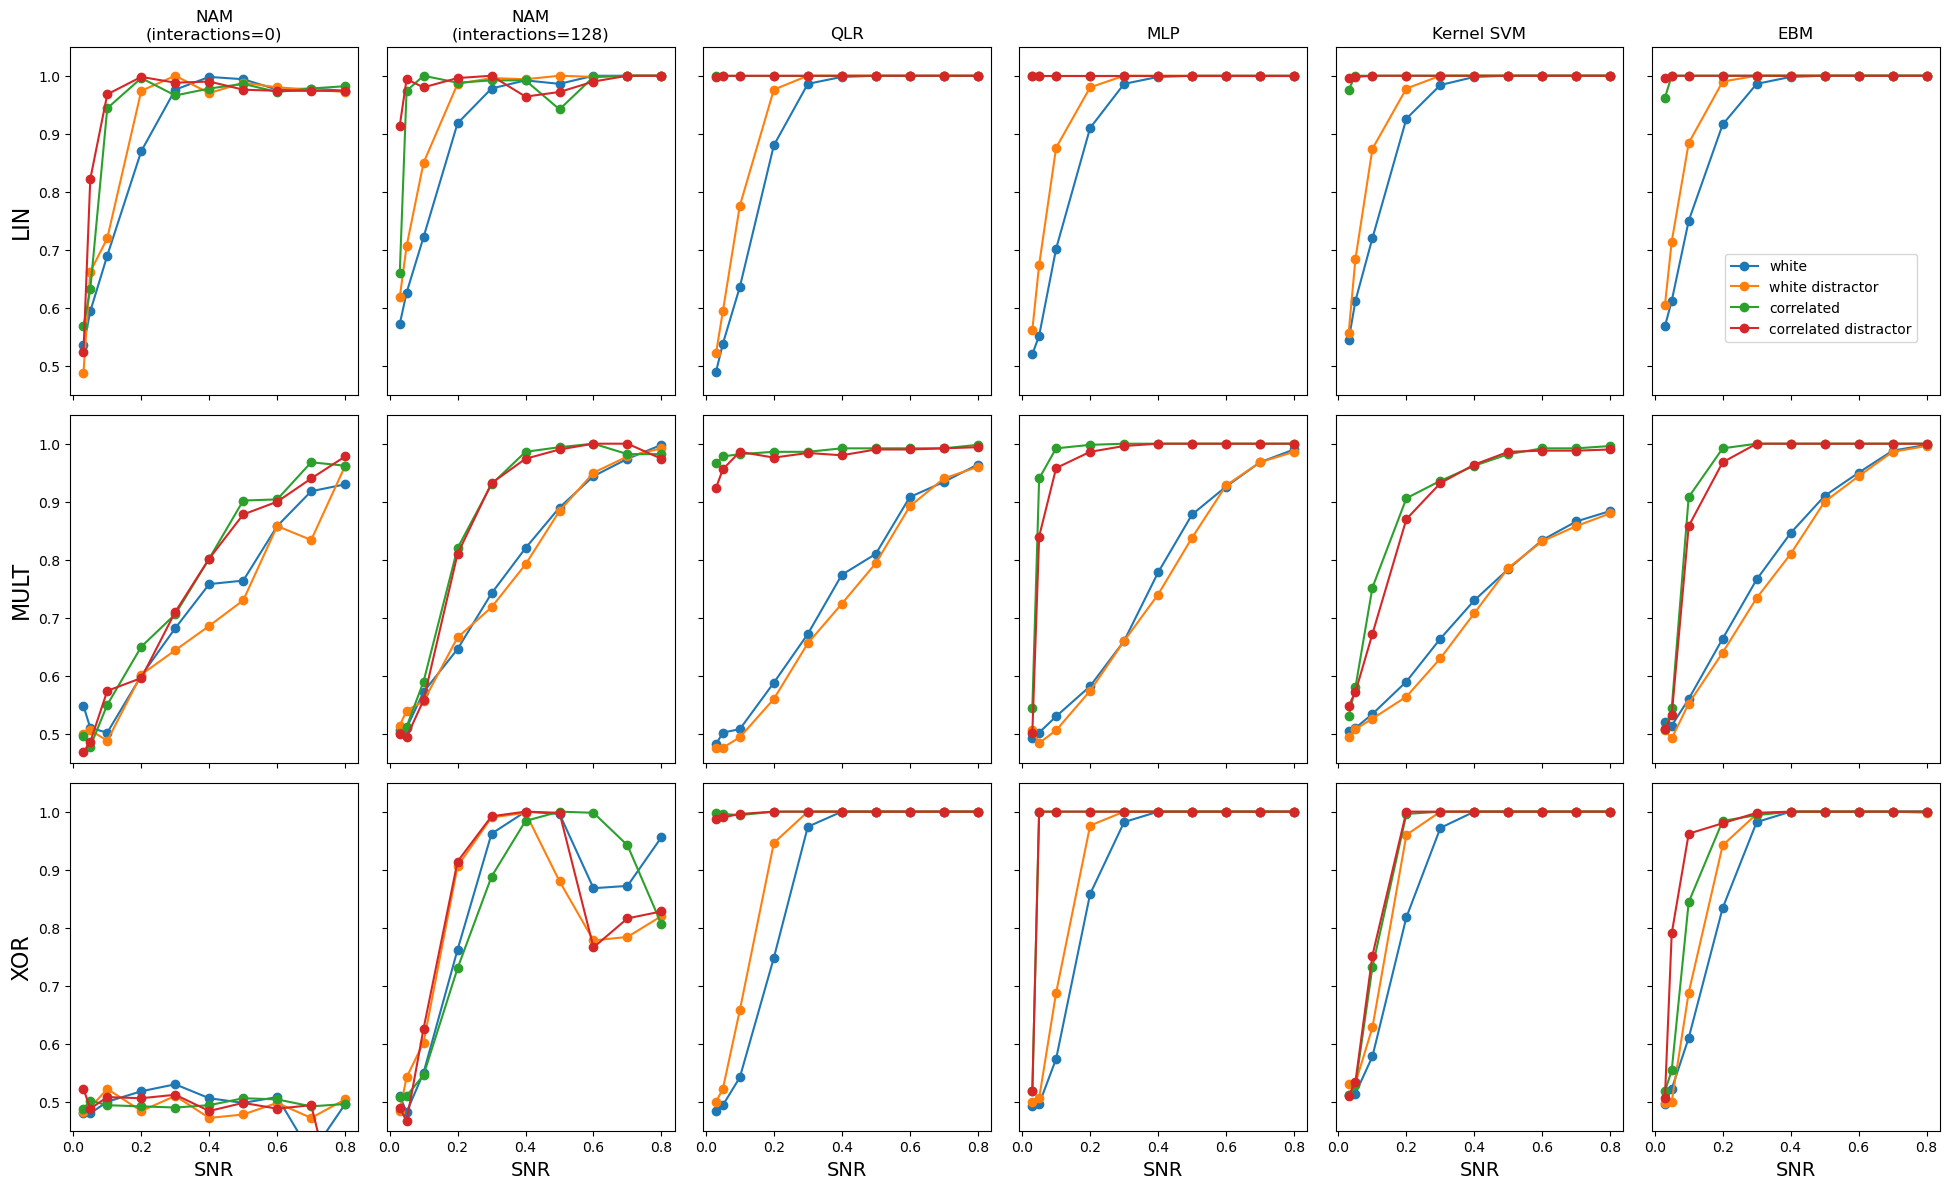

In [ ]:
## We re-ran the kernel svm and EBM stuff due to bugs in accuracy calculation, 
## so here there's 3 separate dataframes merged together, so the df2 and df3 stuff can be dropped
## if all results are from the final code and in one single file.
import pandas as pd
import matplotlib.pyplot as plt
import ast


# Load original data
df1 = pd.read_csv("linesearch_results_final.csv")

# Load Kernel SVM data
df2 = pd.read_csv("linesearch_results_ksvm.csv")

# Normalize scenarios and extract SNRs
for df in [df1, df2]:
    df["base_scenario"] = df["scenario"].apply(lambda x: x.replace("_distractor", ""))
    df["snr"] = df["snr_value"].apply(lambda x: float(x) if isinstance(x, float) or x.replace('.', '', 1).isdigit() else float(ast.literal_eval(x)[0]))

# Merge on scenario, background, and snr
merged_df = pd.merge(df1, df2[["scenario", "background", "snr", "kernel_svm"]],
                     on=["scenario", "background", "snr"], how="outer")
df = merged_df

# Normalize the scenario field (e.g., "xor_distractor" -> "xor")
df["base_scenario"] = df["scenario"].apply(lambda x: x.replace("_distractor", ""))

# Extract first SNR value from tuple or plain float
def extract_snr(s):
    try:
        return float(s)
    except:
        return float(ast.literal_eval(s)[0])  # safely parse the string tuple

df["snr"] = df["snr_value"].apply(extract_snr)

# Define order
scenarios = ["linear", "multiplicative",  "xor"]
scenario_labels = ["LIN", "MULT", "XOR"]

models = ["nam", "nam128", "qlr", "mlp", "kernel_svm"]
model_titles = ["NAM\n(interactions=0)", "NAM\n(interactions=128)", "QLR", "MLP", "Kernel SVM"]

backgrounds = ["white", "correlated"]
distractor_prefix = "_distractor"


threshold = 0.8
results = []

# All scenarios and distractor variants
# scenarios = ["linear", "multiplicative", "translations_rotations", "xor"]
# backgrounds = ["white", "correlated"]
distractor_options = [False, True]

# models = ["nam", "nam128", "qlr", "mlp", "kernel_svm"]

def model_passes(row, model, scenario):
    if scenario == "xor" and model == "nam":
        return True  # Ignore NAM (0 interactions) for XOR
    return pd.notnull(row[model]) and row[model] >= threshold

# Use in main loop:


# Load EBM results
df3 = pd.read_csv("linesearch_results_ebm.csv")

# Normalize scenario and extract SNR
df3["base_scenario"] = df3["scenario"].apply(lambda x: x.replace("_distractor", ""))
df3["snr"] = df3["snr_value"].apply(lambda x: float(x) if isinstance(x, float) or x.replace('.', '', 1).isdigit() else float(ast.literal_eval(x)[0]))

# Merge EBM results
merged_df = pd.merge(merged_df, df3[["scenario", "background", "snr", "ebm"]],
                     on=["scenario", "background", "snr"], how="outer")

df = merged_df  # Update df reference

# Add EBM to model lists
models.append("ebm")
model_titles.append("EBM")



for scenario in scenarios:
    for background in backgrounds:
        for is_distractor in distractor_options:
            scenario_label = scenario + "_distractor" if is_distractor else scenario
            bg_label = f"{'distractor ' if is_distractor else ''}{background}"
            
            subset = merged_df[(merged_df["scenario"] == scenario_label) & (merged_df["background"] == background)].copy()
            if subset.empty:
                results.append((scenario, bg_label, None))
                continue

            subset = subset.sort_values("snr")
            found = False
            for _, row in subset.iterrows():
                if all(model_passes(row, model, scenario) for model in models):
                    results.append((scenario, bg_label, row["snr"]))
                    found = True
                    break
            if not found:
                results.append((scenario, bg_label, None))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["scenario", "background_type", "min_snr_all_models_good"])

print(results_df)


fig, axs = plt.subplots(len(scenarios), len(models), figsize=(20, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, scenario in enumerate(scenarios):
    for j, model in enumerate(models):
        ax = axs[i, j]
        for background in backgrounds:
            for is_distractor in [False, True]:
                if is_distractor:
                    scenario_label = scenario + distractor_prefix
                    label = f"{background} distractor"
                else:
                    scenario_label = scenario
                    label = background

                subset = df[df["scenario"] == scenario_label]
                subset = subset[subset["background"] == background]
                subset = subset.sort_values("snr")

                if not subset.empty:
                    ax.plot(subset["snr"], subset[model], marker='o', label=label)

        if i == 0:
            ax.set_title(model_titles[j])
        if j == 0:
            ax.set_ylabel(scenario_labels[i], fontsize=16)
        if i == len(scenarios) - 1:
            ax.set_xlabel("SNR", fontsize=14)
        if i == 0 and j == len(models) - 1:
            ax.legend(bbox_to_anchor=(0.23, 0.425), loc='upper left')
        ax.set_ylim(0.45,1.05)

plt.tight_layout()
plt.savefig('./figures/xai_tris_linesearch.png', bbox_inches='tight')
plt.savefig('./figures/xai_tris_linesearch_hires.png', dpi=300, bbox_inches='tight')

plt.show()


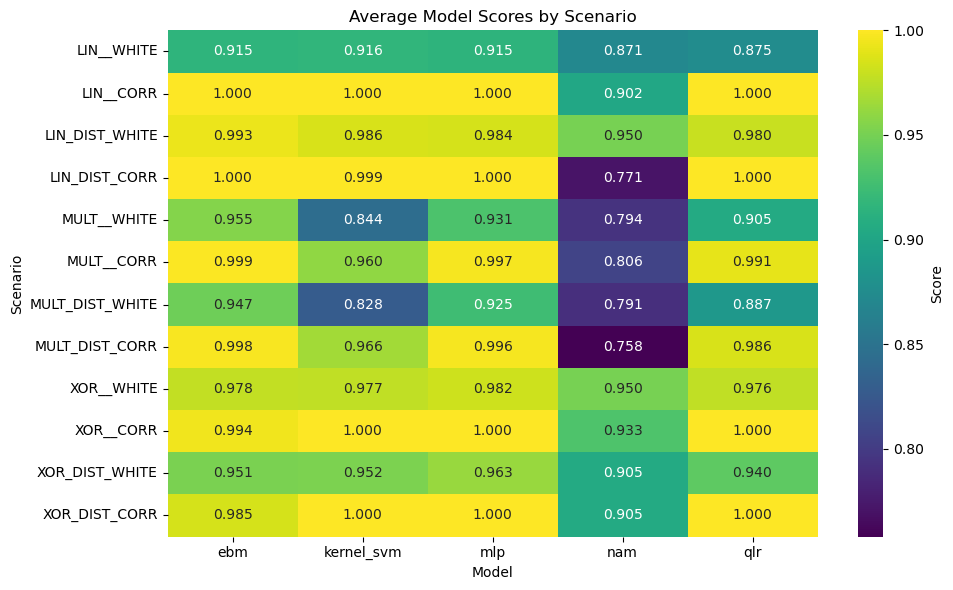

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean base file
df = pd.read_csv('./training_results_xai_tris.csv')
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Load and clean EBM file
df_ebm = pd.read_csv('./training_results_xai_tris_ebm.csv')
df_ebm = df_ebm.drop(columns=[col for col in df_ebm.columns if 'Unnamed' in col])

# Scenario parser
def parse_scenario(s):
    parts = s.split('_')
    scenario_map = {'linear': 'LIN', 'multiplicative': 'MULT', 'xor': 'XOR'}
    background_map = {'white': 'WHITE', 'correlated': 'CORR'}
    return {
        'scenario_label': scenario_map[parts[0]],
        'manip_label': 'DIST' if 'distractor' in parts[1] else '',
        'background_label': background_map[parts[-2]],
        'model_ind': parts[-1]
    }

# Parse both
parsed_df = pd.DataFrame(df['scenario'].apply(parse_scenario).tolist())
df = pd.concat([df, parsed_df], axis=1)
df['scenario_combined'] = df['scenario_label'] + '_' + df['manip_label'] + '_' + df['background_label']

parsed_df_ebm = pd.DataFrame(df_ebm['scenario'].apply(parse_scenario).tolist())
df_ebm = pd.concat([df_ebm, parsed_df_ebm], axis=1)
df_ebm['scenario_combined'] = df_ebm['scenario_label'] + '_' + df_ebm['manip_label'] + '_' + df_ebm['background_label']

# Merge ebm scores
df = df.merge(
    df_ebm[['scenario', 'seed', 'ebm']],
    on=['scenario', 'seed'],
    how='left'
)

df_ksvm = pd.read_csv('./training_results_xai_tris_ksvm.csv')
df_ksvm = df_ksvm.drop(columns=[col for col in df_ksvm.columns if 'Unnamed' in col])

# Parse the scenario in the new df_ksvm (to align keys for merging)
parsed_df_ksvm = pd.DataFrame(df_ksvm['scenario'].apply(parse_scenario).tolist())
df_ksvm = pd.concat([df_ksvm, parsed_df_ksvm], axis=1)

# Replace 'kernel_svm' column in df with new values from df_ksvm based on 'scenario' and 'seed'
df = df.drop(columns=['kernel_svm'])  # drop old column first for clarity
df = df.merge(
    df_ksvm[['scenario', 'seed', 'kernel_svm']],
    on=['scenario', 'seed'],
    how='left'
)

# Ensure model columns are numeric
value_vars = ['nam', 'qlr', 'mlp', 'kernel_svm', 'ebm']
df[value_vars] = df[value_vars].apply(pd.to_numeric, errors='coerce')

# Melt
df_melted = df.melt(
    id_vars=['scenario_combined', 'model_ind', 'seed'],
    value_vars=value_vars,
    var_name='model',
    value_name='score'
)

# Aggregate
df_avg = df_melted.groupby(['scenario_combined', 'model'])['score'].mean().reset_index()
plot_data = df_avg.pivot(index='scenario_combined', columns='model', values='score')

# Custom row order
row_order = []
for scenario in ['LIN', 'MULT', 'XOR']:
    for dist in ['', 'DIST']:
        for bg in ['WHITE', 'CORR']:
            row_order.append(f"{scenario}_{dist}_{bg}".strip('_'))

# Filter and reorder
row_order = [r for r in row_order if r in plot_data.index]
plot_data = plot_data.loc[row_order]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(plot_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Score'})
plt.title("Average Model Scores by Scenario")
plt.xlabel("Model")
plt.ylabel("Scenario")
plt.tight_layout()
plt.show()


In [ ]:
# Compute mean and std
agg_df = df_melted.groupby(['scenario_combined', 'model'])['score'].agg(['mean', 'std']).reset_index()

import re
scenario_to_snr = {}
for s in df['scenario'].unique():
    match = re.search(r'(\d+\.\d+)', s)
    if match:
        snr = float(match.group(1))
        parsed = parse_scenario(s)
        key = parsed['scenario_label'] + '_' + parsed['manip_label'] + '_' + parsed['background_label']
        scenario_to_snr[key] = snr

# Add SNR column
agg_df['SNR'] = agg_df['scenario_combined'].map(scenario_to_snr)

# Format mean ± std rounded to 3 decimals
agg_df['score_formatted'] = agg_df.apply(
    lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
)

# Pivot to wide format
table_df = agg_df.pivot(index='scenario_combined', columns='model', values='score_formatted')

# Insert SNR column at the front
# table_df.insert(0, 'SNR', table_df.index.map(scenario_to_snr))
table_df.insert(0, 'SNR', table_df.index.map(lambda k: f"{scenario_to_snr[k]:.2f}" if k in scenario_to_snr else "--"))

# Enforce row order
ordered_rows = [
    'LIN__WHITE', 'LIN__CORR', 'LIN_DIST_WHITE', 'LIN_DIST_CORR',
    'MULT__WHITE', 'MULT__CORR', 'MULT_DIST_WHITE', 'MULT_DIST_CORR',
    'XOR__WHITE', 'XOR__CORR', 'XOR_DIST_WHITE', 'XOR_DIST_CORR'
]

col_order = ['SNR', 'nam', 'qlr', 'mlp', 'kernel_svm', 'ebm']

table_df = table_df.loc[[r for r in ordered_rows if r in table_df.index]]

# table_df

# Output to LaTeX
latex_table = table_df[col_order].to_latex(
    index=True,
    caption="Mean ± Std of Model Scores by Scenario with SNR",
    label="tab:model_scores_snr_std",
    column_format='l' + 'r' * len(table_df.columns),
    escape=False,
    na_rep='--'
)

print(latex_table)


\begin{table}
\caption{Mean ± Std of Model Scores by Scenario with SNR}
\label{tab:model_scores_snr_std}
\begin{tabular}{lrrrrrr}
\toprule
model & SNR & nam & qlr & mlp & kernel_svm & ebm \\
scenario_combined &  &  &  &  &  &  \\
\midrule
LIN__WHITE & 0.20 & 0.87 ± 0.02 & 0.88 ± 0.02 & 0.91 ± 0.01 & 0.92 ± 0.01 & 0.92 ± 0.01 \\
LIN__CORR & 0.10 & 0.90 ± 0.06 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 \\
LIN_DIST_WHITE & 0.20 & 0.95 ± 0.03 & 0.98 ± 0.00 & 0.98 ± 0.00 & 0.99 ± 0.01 & 0.99 ± 0.00 \\
LIN_DIST_CORR & 0.05 & 0.77 ± 0.06 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 \\
MULT__WHITE & 0.60 & 0.79 ± 0.05 & 0.90 ± 0.02 & 0.93 ± 0.01 & 0.84 ± 0.02 & 0.95 ± 0.01 \\
MULT__CORR & 0.40 & 0.81 ± 0.04 & 0.99 ± 0.00 & 1.00 ± 0.00 & 0.96 ± 0.01 & 1.00 ± 0.00 \\
MULT_DIST_WHITE & 0.60 & 0.79 ± 0.05 & 0.89 ± 0.02 & 0.92 ± 0.01 & 0.83 ± 0.02 & 0.95 ± 0.01 \\
MULT_DIST_CORR & 0.40 & 0.76 ± 0.04 & 0.99 ± 0.01 & 1.00 ± 0.01 & 0.97 ± 0.02 & 1.00 ± 0.00 \\
XOR__WHITE & 0.30